In [53]:
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API
from tensorflow import keras

# Deep learning
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping

In [89]:

def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of
    deep learning models
    """
    # Extracting the number of features that are passed from the array
    n_features = ts.shape[1]

    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

Traceback (most recent call last):
  File "D:\Program Files\JetBrains\PyCharm 2021.1.2\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_utils.py", line 69, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


In [55]:

d = pd.read_csv('data/weather.csv')

print(f'Shape of data: {d.shape}')

Shape of data: (294227, 25)


In [56]:
d.dtypes

dt                       int64
dt_iso                  object
timezone                 int64
city_name               object
lat                    float64
lon                    float64
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure                 int64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_1h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [57]:
# Converting the dt column to datetime object
d['dt'] = [datetime.datetime.utcfromtimestamp(x) for x in d['dt']]

# Sorting by the date
d.sort_values('dt', inplace=True)

In [58]:
# Listing the min and the max dates
print(f"First date {min(d['dt'])}")
print(f"Most recent date {max(d['dt'])}")

First date 1990-01-01 00:00:00
Most recent date 2020-11-30 23:00:00


In [59]:
print(f"Total unique dates in the dataset: {len(set(d['dt']))}")

Total unique dates in the dataset: 271008


In [60]:
print(f"Number of rows in the dataset: {d.shape[0]}")

Number of rows in the dataset: 294227


In [61]:
# Features used in models
features = ['temp', 'pressure', 'wind_speed']

In [62]:
# Aggregating to hourly level
d = d.groupby('dt', as_index=False)[features].mean()

# Creating the data column
d['date'] = [x.date() for x in d['dt']]

In [63]:
d[features].describe()

,temp,pressure,wind_speed
count,271008.000000,271008.000000,271008.000000
mean,7.122913,1014.778763,3.763613
std,9.421923,9.938621,2.075273
min,-28.970000,964.000000,0.020000
25%,0.330000,1009.000000,2.100000
50%,6.930000,1015.000000,3.100000
75%,14.330000,1021.000000,5.100000
max,33.980000,1056.000000,27.800000


In [64]:
d.head(10)

,dt,temp,pressure,wind_speed,date
0,1990-01-01 00:00:00,-7.52,1032.0,2.00,1990-01-01
1,1990-01-01 01:00:00,-7.56,1032.0,2.00,1990-01-01
2,1990-01-01 02:00:00,-7.67,1028.0,2.08,1990-01-01
3,1990-01-01 03:00:00,-7.74,1028.0,2.18,1990-01-01
4,1990-01-01 04:00:00,-7.66,1028.0,2.12,1990-01-01
5,1990-01-01 05:00:00,-7.08,1030.0,2.00,1990-01-01
6,1990-01-01 06:00:00,-7.01,1030.0,2.00,1990-01-01
7,1990-01-01 07:00:00,-6.93,1030.0,2.00,1990-01-01
8,1990-01-01 08:00:00,-6.32,1026.0,2.22,1990-01-01
9,1990-01-01 09:00:00,-6.07,1026.0,2.23,1990-01-01


In [65]:
d[['dt', 'temp']].tail(10)

,dt,temp
270998,2020-11-30 14:00:00,-0.56
270999,2020-11-30 15:00:00,-0.57
271000,2020-11-30 16:00:00,-0.74
271001,2020-11-30 17:00:00,-0.92
271002,2020-11-30 18:00:00,-0.93
271003,2020-11-30 19:00:00,-0.92
271004,2020-11-30 20:00:00,-0.85
271005,2020-11-30 21:00:00,-0.85
271006,2020-11-30 22:00:00,-0.85
271007,2020-11-30 23:00:00,-0.67


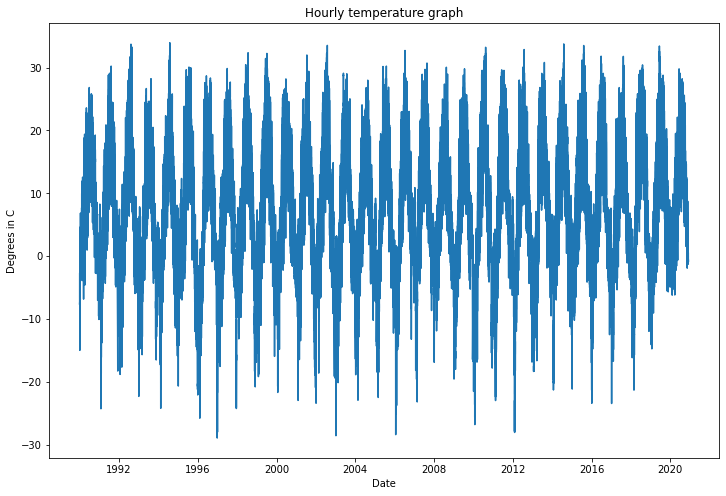

In [66]:
plt.figure(figsize=(12, 8))
plt.plot('dt', 'temp', data=d)
plt.title('Hourly temperature graph')
plt.ylabel('Degrees in C')
plt.xlabel('Date')
plt.show()

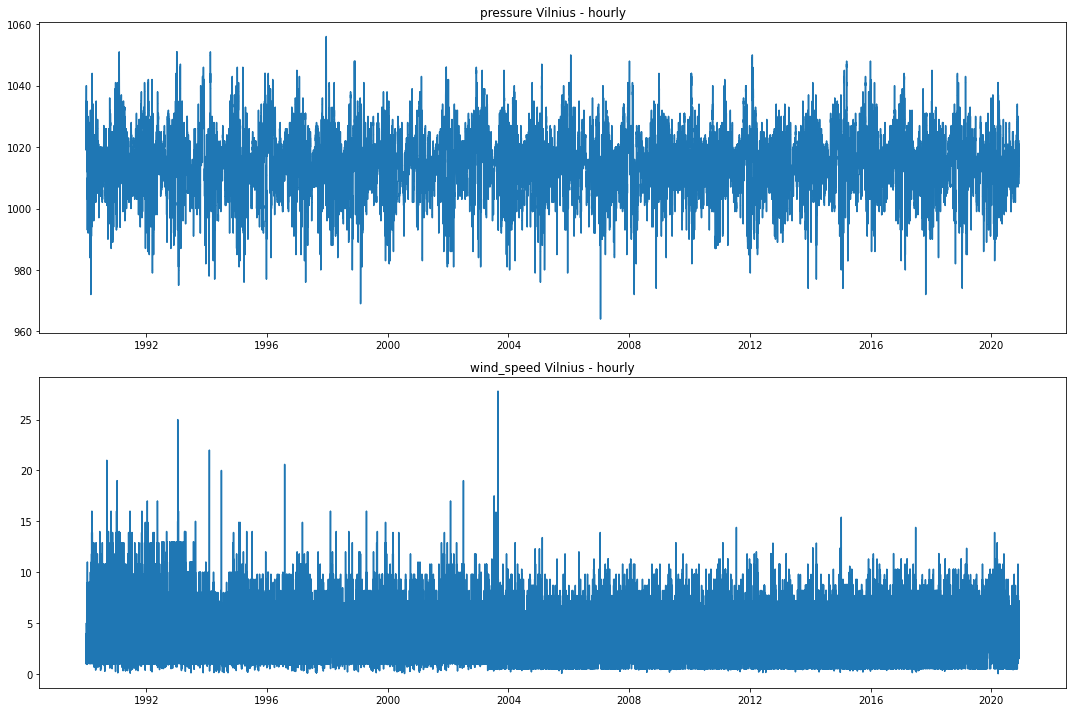

In [67]:
plot_features = d[features]
plot_features.index = d.dt

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    facecolor="w",
    edgecolor="k"
)

for i, feature in enumerate(['pressure', 'wind_speed']):
    axes[i % 2].plot(plot_features[feature])
    axes[i % 2].set_title(f'{feature} Vilnius - hourly')

plt.tight_layout()

plt.show()

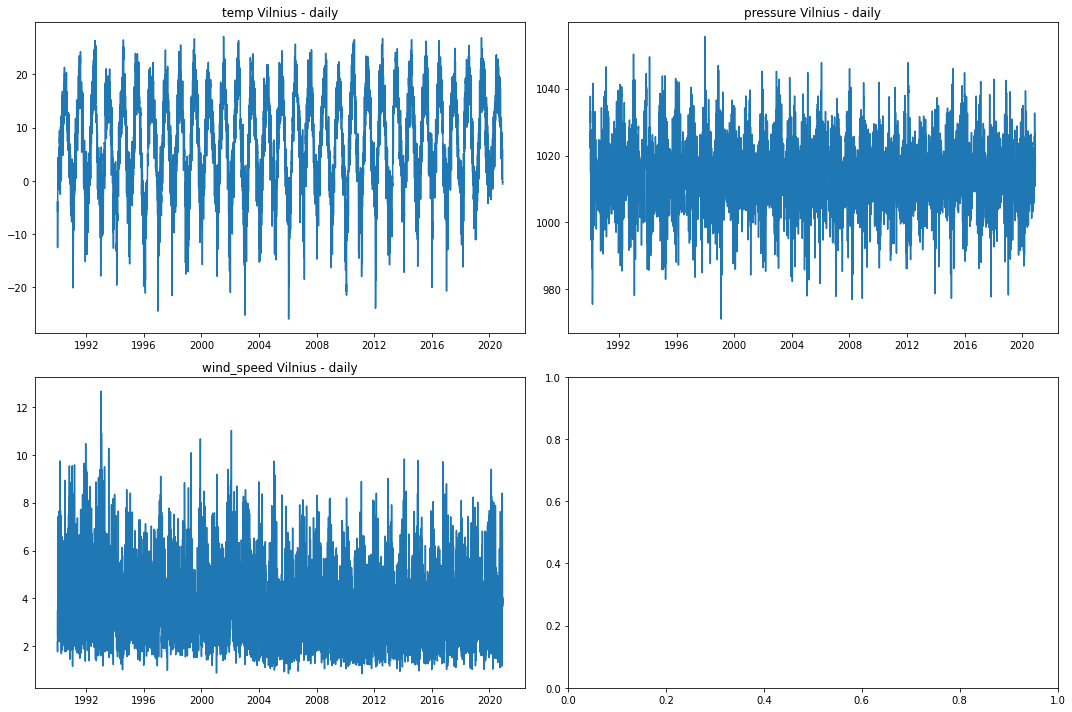

In [68]:
plot_features = d.groupby('date')[features].mean()

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(15, 10),
    facecolor="w",
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Vilnius - daily')

plt.tight_layout()

plt.show()

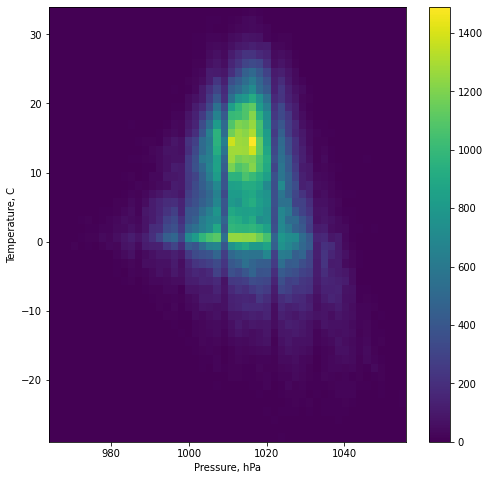

In [69]:
plt.figure(figsize=(8, 8))
plt.hist2d(d['pressure'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Pressure, hPa')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

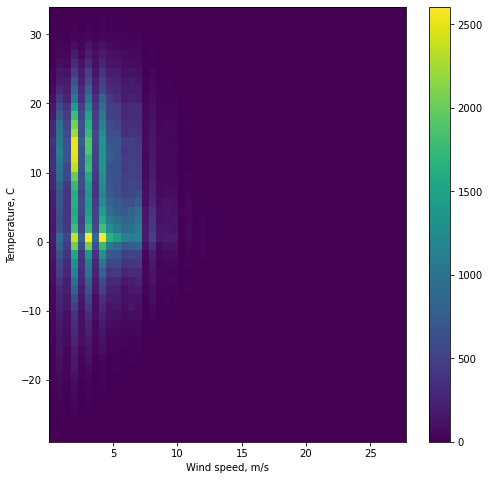

In [70]:
plt.figure(figsize=(8, 8))
plt.hist2d(d['wind_speed'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Wind speed, m/s')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

In [71]:
# Extracting the hour of day
d['hour'] = [x.hour for x in d['dt']]

# Extracting the month of the year
d['month'] = [x.month for x in d['dt']]
d

,dt,temp,pressure,wind_speed,date,hour,month
0,1990-01-01 00:00:00,-7.52,1032.0,2.00,1990-01-01,0,1
1,1990-01-01 01:00:00,-7.56,1032.0,2.00,1990-01-01,1,1
2,1990-01-01 02:00:00,-7.67,1028.0,2.08,1990-01-01,2,1
3,1990-01-01 03:00:00,-7.74,1028.0,2.18,1990-01-01,3,1
4,1990-01-01 04:00:00,-7.66,1028.0,2.12,1990-01-01,4,1
...,...,...,...,...,...,...,...
271003,2020-11-30 19:00:00,-0.92,1021.0,4.10,2020-11-30,19,11
271004,2020-11-30 20:00:00,-0.85,1022.0,4.60,2020-11-30,20,11
271005,2020-11-30 21:00:00,-0.85,1022.0,5.70,2020-11-30,21,11
271006,2020-11-30 22:00:00,-0.85,1022.0,6.20,2020-11-30,22,11


<AxesSubplot:title={'center':'temp'}, xlabel='hour'>

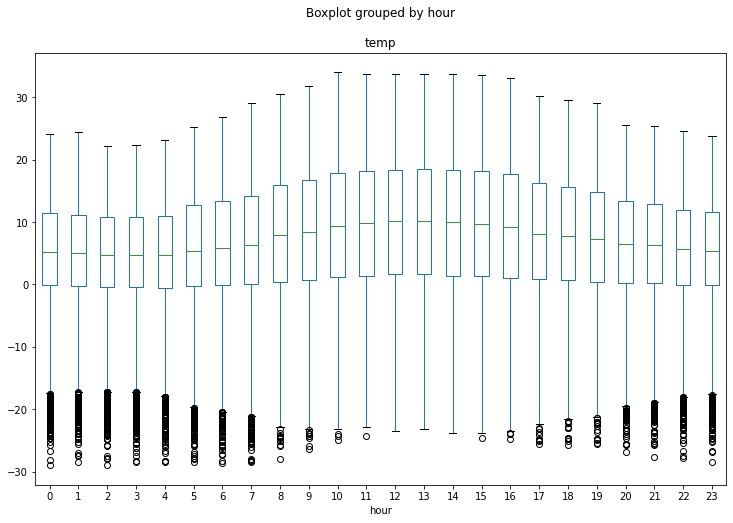

In [72]:
d.boxplot('temp', by='hour', figsize=(12, 8), grid=False)

<AxesSubplot:title={'center':'temp'}, xlabel='month'>

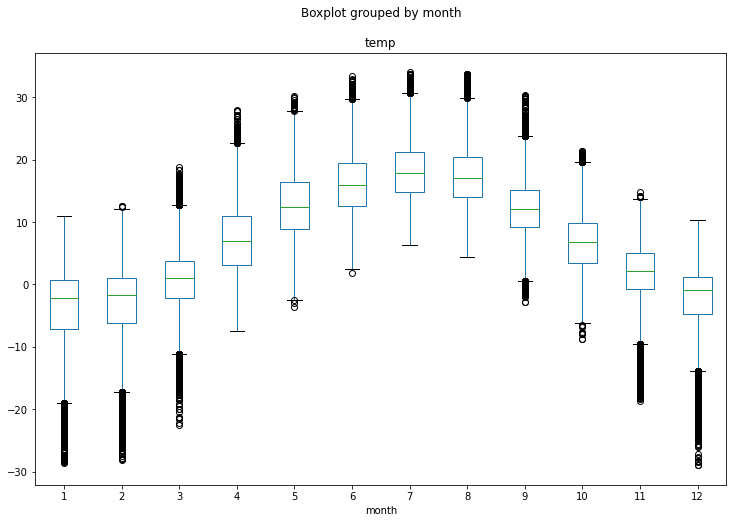

In [73]:
d.boxplot('temp', by='month', figsize=(12, 8), grid=False)

In [74]:
# Creating the cyclical daily feature
d['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in d['hour']]
d['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in d['hour']]

In [75]:
dsin = d[['dt', 'temp', 'hour', 'day_sin', 'day_cos']].head(25).copy()
dsin['day_sin'] = [round(x, 3) for x in dsin['day_sin']]
dsin['day_cos'] = [round(x, 3) for x in dsin['day_cos']]

dsin

,dt,temp,hour,day_sin,day_cos
0,1990-01-01 00:00:00,-7.52,0,0.000,1.000
1,1990-01-01 01:00:00,-7.56,1,0.259,0.966
2,1990-01-01 02:00:00,-7.67,2,0.500,0.866
3,1990-01-01 03:00:00,-7.74,3,0.707,0.707
4,1990-01-01 04:00:00,-7.66,4,0.866,0.500
5,1990-01-01 05:00:00,-7.08,5,0.966,0.259
6,1990-01-01 06:00:00,-7.01,6,1.000,0.000
7,1990-01-01 07:00:00,-6.93,7,0.966,-0.259
8,1990-01-01 08:00:00,-6.32,8,0.866,-0.500
9,1990-01-01 09:00:00,-6.07,9,0.707,-0.707


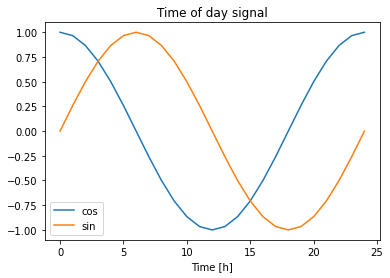

In [76]:
# Ploting the first 25 hours
plt.plot(np.array(d['day_cos'])[:25], label='cos')
plt.plot(np.array(d['day_sin'])[:25], label='sin')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

In [77]:
# Extracting the timestamp from the datetime object
d['timestamp'] = [x.timestamp() for x in d['dt']]

# Seconds in day
s = 24 * 60 * 60

# Seconds in year
year = (365.25) * s

d['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in d['timestamp']]
d['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in d['timestamp']]

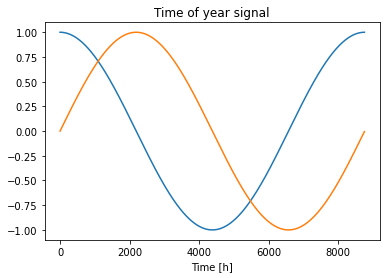

In [78]:
# Ploting the first year
plt.plot(np.array(d['month_cos'])[:24 * 365])
plt.plot(np.array(d['month_sin'])[:24 * 365])
plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.show()

In [79]:
# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast
n_ahead = 1

# Share of obs in testing
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

# The features used in the modeling
features_final = ['temp', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'pressure', 'wind_speed']

In [80]:
d[features_final].head(10)

,temp,day_cos,day_sin,month_sin,month_cos,pressure,wind_speed
0,-7.52,1.000000e+00,0.000000,-4.898587e-15,1.000000,1032.0,2.00
1,-7.56,9.659258e-01,0.258819,7.167676e-04,1.000000,1032.0,2.00
2,-7.67,8.660254e-01,0.500000,1.433535e-03,0.999999,1028.0,2.08
3,-7.74,7.071068e-01,0.707107,2.150301e-03,0.999998,1028.0,2.18
4,-7.66,5.000000e-01,0.866025,2.867067e-03,0.999996,1028.0,2.12
5,-7.08,2.588190e-01,0.965926,3.583831e-03,0.999994,1030.0,2.00
6,-7.01,6.123234e-17,1.000000,4.300593e-03,0.999991,1030.0,2.00
7,-6.93,-2.588190e-01,0.965926,5.017353e-03,0.999987,1030.0,2.00
8,-6.32,-5.000000e-01,0.866025,5.734110e-03,0.999984,1026.0,2.22
9,-6.07,-7.071068e-01,0.707107,6.450864e-03,0.999979,1026.0,2.23


In [81]:
# Subseting only the needed columns
ts = d[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame
ts_s = pd.concat([train, test])

In [82]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [83]:
# Spliting into train and test sets
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [84]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (243863, 48, 7)
Shape of the target data: (243863, 1)
Shape of validation data: (27096, 48, 7)
Shape of the validation target data: (27096, 1)


In [85]:
class NNMultistepModel():

    def __init__(
        self,
        X,
        Y,
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs,
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)

        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model
        empty_model = self.model

        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X,
                self.Y,
                epochs=self.epochs,
                batch_size=self.batch,
                validation_data=(self.Xval, self.Yval),
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X,
                self.Y,
                epochs=self.epochs,
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )

        # Saving to original model attribute in the class
        self.model = empty_model

        # Returning the training history
        return history

    def predict(self, X):
        return self.model.predict(X)

In [86]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs,
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [87]:
model.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                720       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


In [88]:
history = model.train()

Epoch 1/20
477/477 [==============================] - 8s 16ms/step - loss: 0.3879 - val_loss: 0.1544

KeyboardInterrupt: 

In [ ]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

In [ ]:
# Creating the frame to store both predictions
days = d['dt'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [ ]:
pivoted.tail(10)

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - scaled data')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()

In [ ]:
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [ ]:
pivoted.tail(10)

In [ ]:
print(f"Average absolute mean error: {round(pivoted['res_abs'].sum() / pivoted.shape[0], 2)} C")

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res, bins=40, edgecolor='black')
plt.title('Distribution of errors')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res_abs, bins=40, edgecolor='black')
plt.title('Distribution of absolute errors')
plt.show()

In [ ]:
pivoted.res_abs.describe()